In [5]:
file_prefix <- "ch18.2"
reuse_fit <- T
source("preset.R")

In [6]:
input_file <- "data/Guber1999data.csv"
x_names <- c("Spend", "PrcntTake", "SpendXPrcnt")
y_name <- "SATT"
coeff_names <- map_chr(1:length(x_names), ~"beta_" %+% .x)

# data

In [7]:
data <- read_csv(input_file) %>% 
  mutate(SpendXPrcnt = Spend * PrcntTake)
stan_data <- list(
  N = nrow(data), 
  K = length(x_names), 
  x = data %>% select(x_names) %>% as.matrix(),
  y = data[[y_name]]
)

Parsed with column specification:
cols(
  State = col_character(),
  Spend = col_double(),
  StuTeaRat = col_double(),
  Salary = col_double(),
  PrcntTake = col_double(),
  SATV = col_double(),
  SATM = col_double(),
  SATT = col_double()
)



In [8]:
fit <- stan(file = "model/ch18.2.stan", data = stan_data, seed = 123, 
            pars = c("nu_minus1"), include = F, 
            chains = 4, warmup = 300, iter = 10000, thin = 2) 

In [9]:
save(fit, file = save_file_name("fit"))
load(file = save_file_name("fit"))

In [10]:
fit

Inference for Stan model: ch18.
4 chains, each with iter=10000; warmup=300; thin=2; 
post-warmup draws per chain=4850, total post-warmup draws=19400.

           mean se_mean    sd    2.5%     25%     50%     75%   97.5% n_eff
alpha   1053.06    0.47 43.74  966.73 1024.09 1052.89 1081.91 1140.17  8487
beta[1]    1.49    0.09  8.21  -14.89   -3.92    1.54    6.91   17.49  8733
beta[2]   -4.22    0.01  0.85   -5.90   -4.78   -4.22   -3.66   -2.58  8796
beta[3]    0.23    0.00  0.14   -0.04    0.14    0.23    0.32    0.51  8418
sigma     31.10    0.03  3.82   24.11   28.50   30.86   33.46   39.30 13992
nu        34.71    0.23 29.48    4.61   13.83   25.69   46.38  113.81 16797
lp__    -210.58    0.02  1.81 -215.01 -211.54 -210.24 -209.25 -208.08 11587
        Rhat
alpha      1
beta[1]    1
beta[2]    1
beta[3]    1
sigma      1
nu         1
lp__       1

Samples were drawn using NUTS(diag_e) at Wed Jan 15 23:25:49 2020.
For each parameter, n_eff is a crude measure of effective sample size

In [ ]:
#ggs_traceplot(ggs(fit, inc_warmup = F))

# result

In [11]:
res <- fit_to_tibble(fit) %>% 
  mutate(log_nu = log10(nu)) %>% 
  add_linear_regression_Rsq(data, coeff_names, x_names, y_name) 

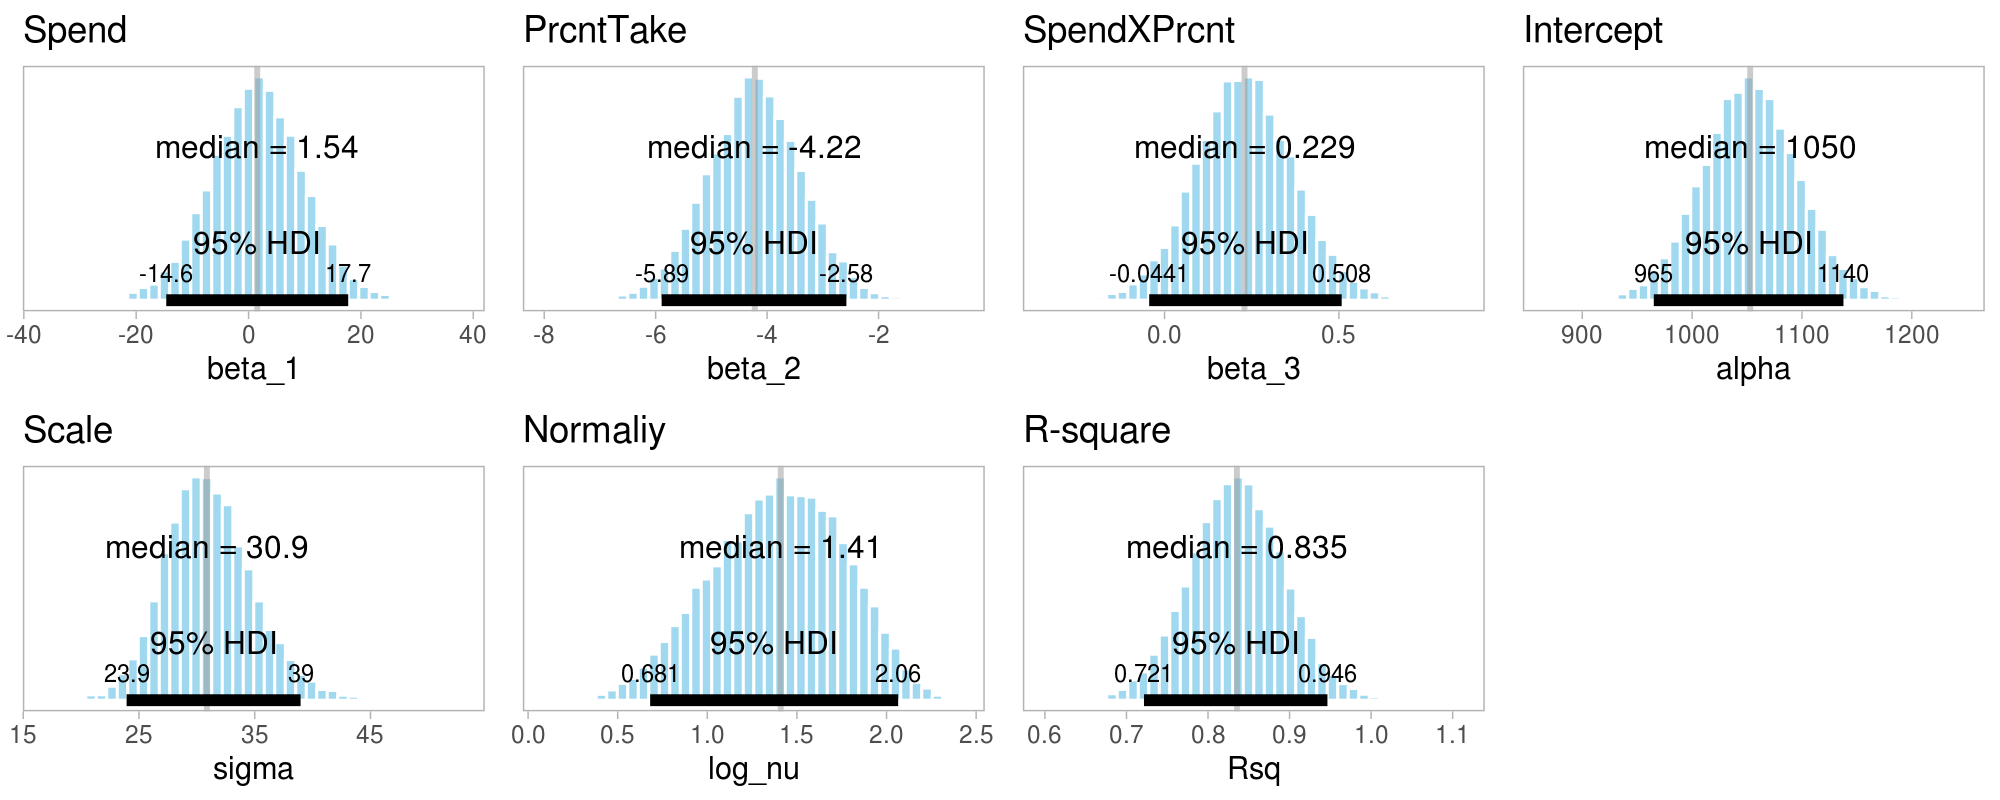

In [14]:
set_plot_size(10, 4)
grid.arrange(
  grobs = map2(
    c(coeff_names, "alpha", "sigma", "log_nu", "Rsq"), 
    c(x_names, "Intercept", "Scale", "Normaliy", "R-square"), 
    ~plot_post(res, param_name = .x, title = .y)), 
  ncol = 4
)

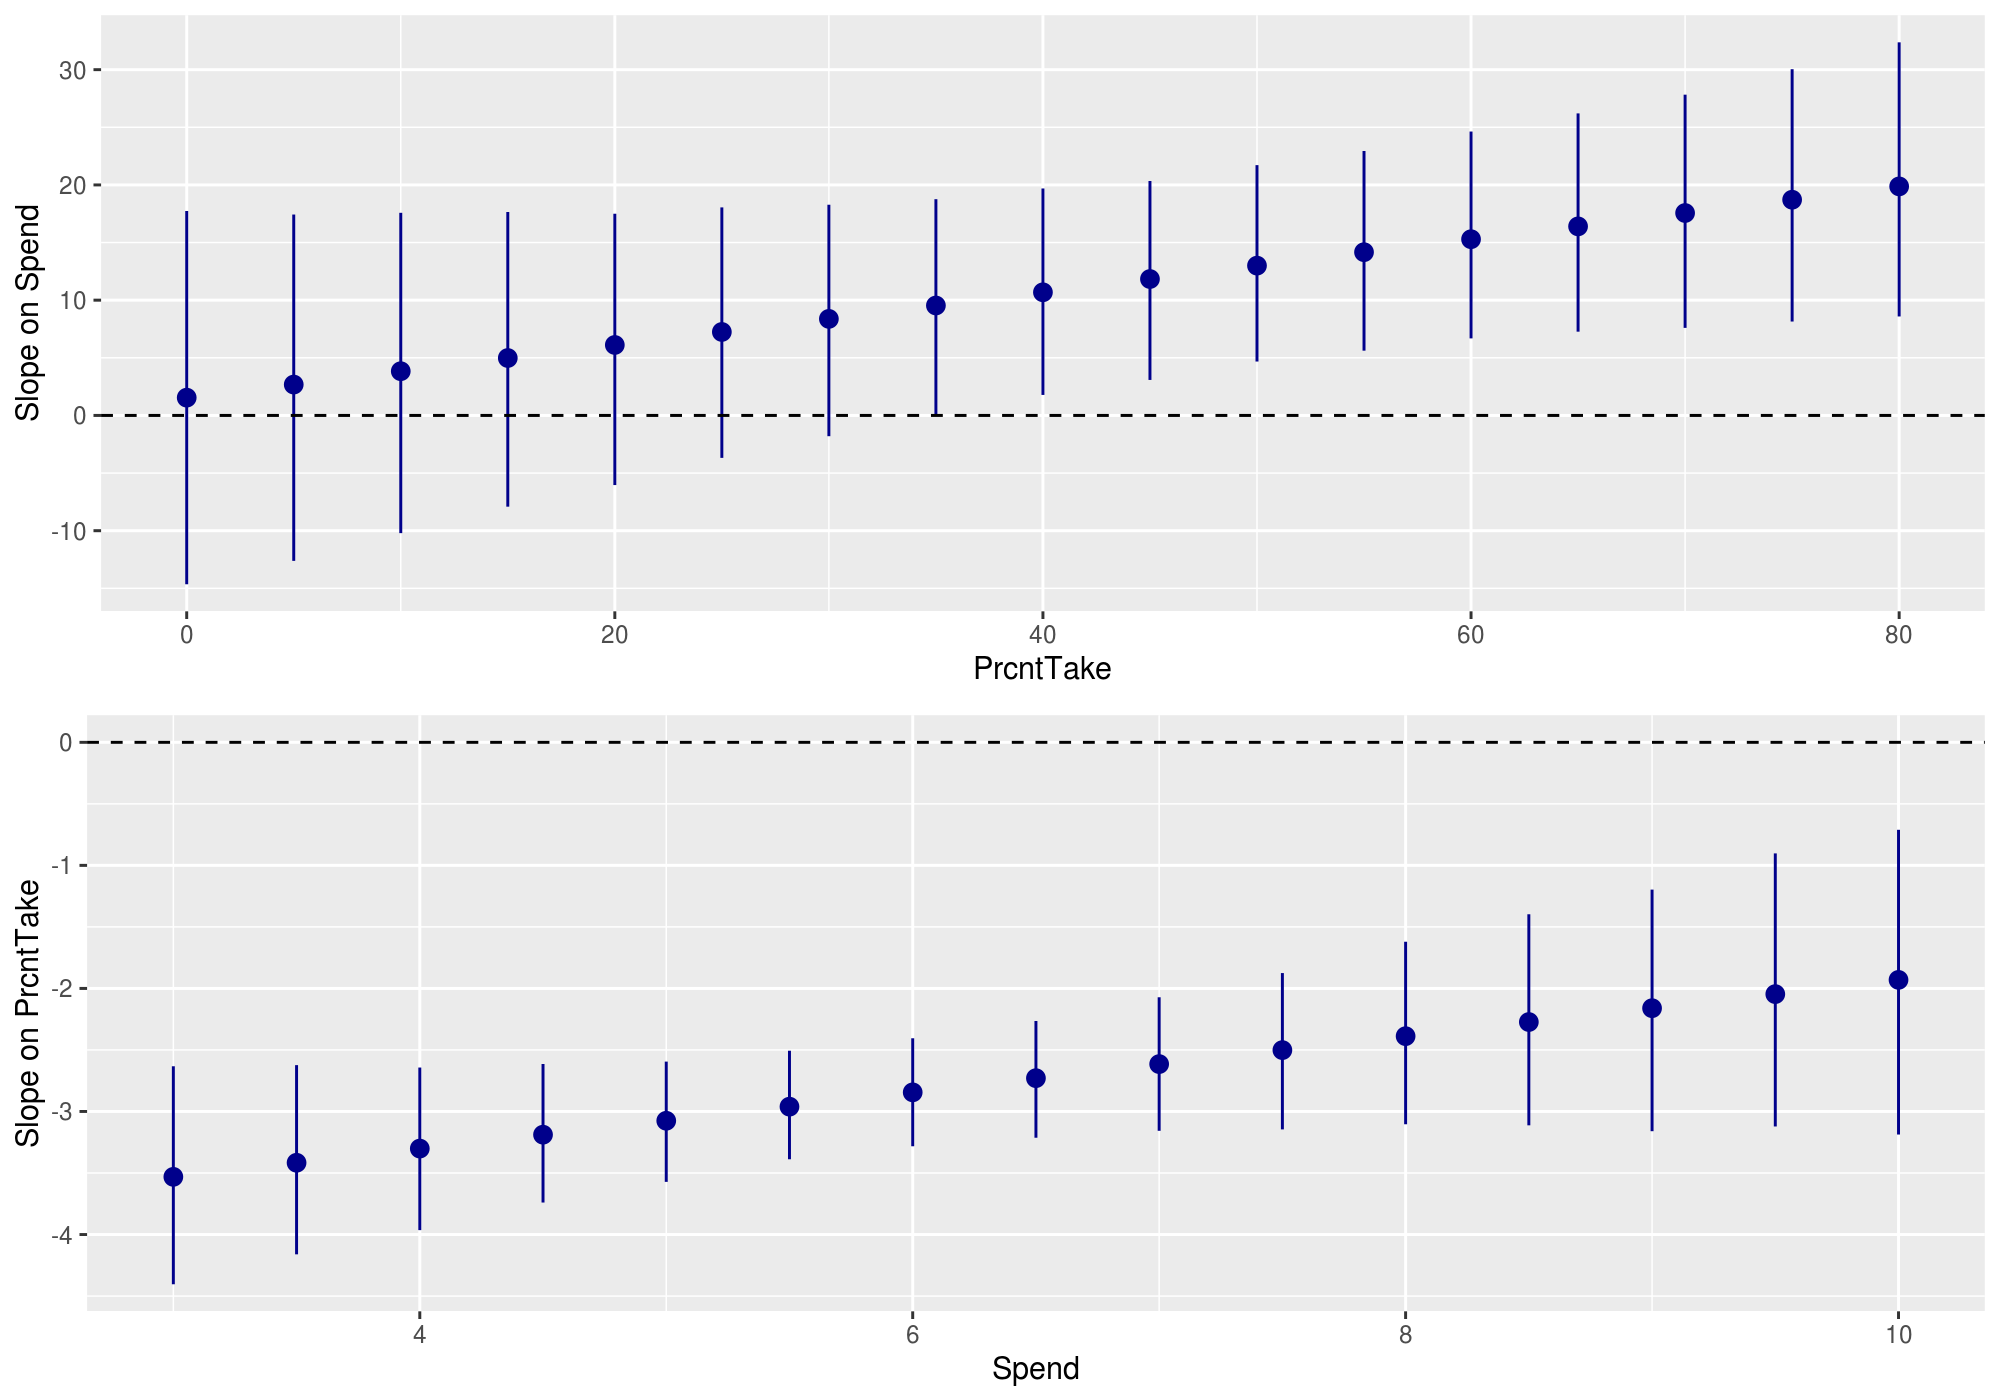

In [18]:
set_plot_size(10, 7)
plot_slope_by_other <- function(res, coeff, inter_coeff, other_xs, x_name, y_name, ci = 0.95) {
  coeff <- enquo(coeff); inter_coeff <- enquo(inter_coeff)
  res %>% select(!!coeff, !!inter_coeff) %>%
    make_line_grid(xs = other_xs, y_func = !!coeff + !!inter_coeff * X) %>% 
    group_by(X) %>% 
    summarise(
      slope = median(Y), 
      low = hdi(Y, ci = ci)$CI_low, 
      high = hdi(Y, ci = ci)$CI_high
    ) %>% 
    ggplot(aes(X, slope, ymin = low, ymax = high)) + 
      geom_pointrange(color = "darkblue") + 
      geom_hline(yintercept = 0, linetype = "dashed") + 
      labs(x = x_name, y = "Slope on " %+% y_name)
}
grid.arrange(
  plot_slope_by_other(res, beta_1, beta_3, seq(0, 80, 5), x_name = "PrcntTake", y_name = "Spend"), 
  plot_slope_by_other(res, beta_2, beta_3, seq(3, 10, 0.5), x_name = "Spend", y_name = "PrcntTake"), 
  ncol = 1
) 